In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import beta
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)
import pandas as pd

from pyplr import stlab
from pyplr.calibrate import CalibrationContext

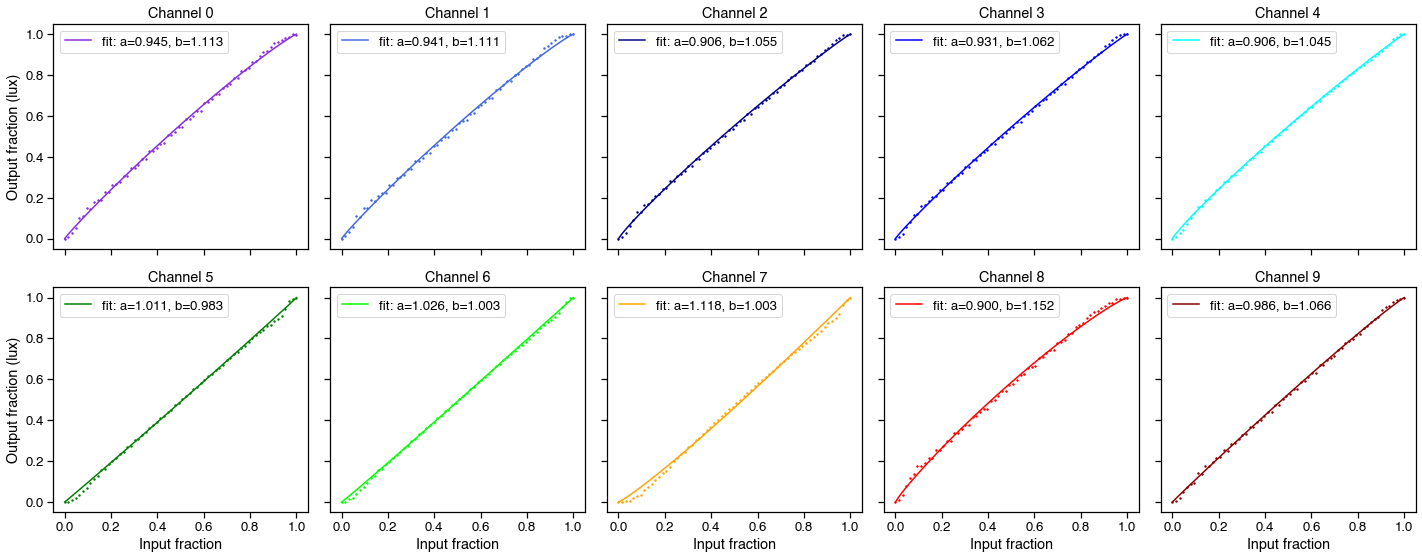

In [2]:
# load the sample spectra and convert to melanopic irradiance
cc = CalibrationContext('../data/S2_corrected_oo_spectra.csv', binwidth=1)

colors = stlab.get_led_colors()

fig, axs = plt.subplots(2,5, figsize=(20,8), sharex=True, sharey=True)
axs = [item for sublist in axs for item in sublist]

ir = cc.irradiance.loc[:, range(0,4096,65), :]

for idx, df in ir.groupby(level=0):
    xdata = df.index.get_level_values(1).to_numpy() / 4095
    ydata = df.values
    ydata = ydata / np.max(ydata)
    
    # Defines function we want to fit
    def func(x, a, b):
        return beta.cdf(x, a, b)

    axs[idx].scatter(xdata, ydata, color=colors[idx], s=2)
    
    # Fit
    popt, pcov = curve_fit(beta.cdf, xdata, ydata, p0=[2.0, 1.0])
    ypred = func(xdata, *popt)
    axs[idx].plot(xdata, ypred, color=colors[idx], label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
    axs[idx].set_title('Channel {}'.format(idx))
    axs[idx].legend()
    
for ax in [axs[0],axs[5]]:
    ax.set_ylabel('Output fraction (lux)')
for ax in axs[5:]:
    ax.set_xlabel('Input fraction')
#for ax in axs:
#    ax.set_aspect('equal', 'box')

plt.tight_layout()
#fig.savefig('../img/STLAB_luminance_linearity.svg')

In [39]:
cc.data.index.get_level_values(1).unique().to_numpy()

array([   0,   65,  130,  195,  260,  325,  390,  455,  520,  585,  650,
        715,  780,  845,  910,  975, 1040, 1105, 1170, 1235, 1300, 1365,
       1430, 1495, 1560, 1625, 1690, 1755, 1820, 1885, 1950, 2015, 2080,
       2145, 2210, 2275, 2340, 2405, 2470, 2535, 2600, 2665, 2730, 2795,
       2860, 2925, 2990, 3055, 3120, 3185, 3250, 3315, 3380, 3445, 3510,
       3575, 3640, 3705, 3770, 3835, 3900, 3965, 4030, 4095])

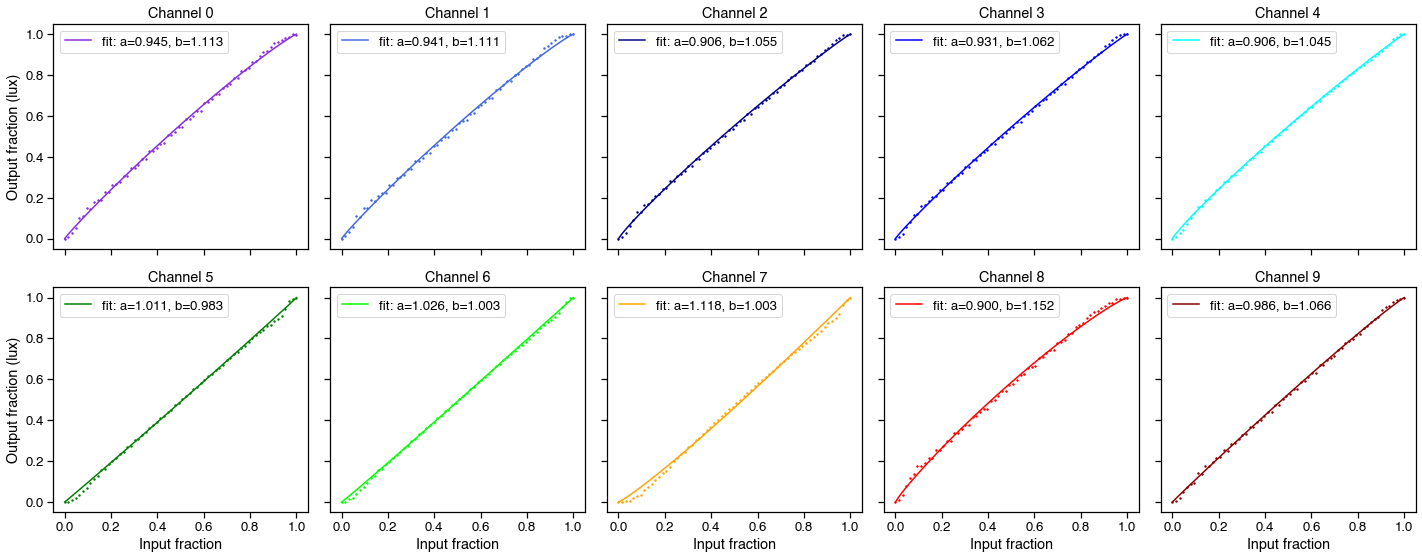

In [3]:
fig = cc.optimise()

In [9]:
cc.linearize(led=7, intensities=np.array([20, 3050]))

array([  34, 3141])

In [7]:
cc.curveparams[1][0]

0.9412053074848692

In [12]:
popt

array([0.96163373, 1.10115187])

In [13]:
pcov

array([[0.00010344, 0.00011086],
       [0.00011086, 0.00013892]])

In [6]:
cc.irradiance.to_frame()

0
led intensity           
0   0           0.000133
    1           0.001150
    2           0.002166
    3           0.003183
    4           0.004199
...                  ...
9   4091       11.576871
    4092       11.578461
    4093       11.580052
    4094       11.581642
    4095       11.583233

[40960 rows x 1 columns]

In [27]:
var = beta.ppf(.5, popt[0], popt[1])

In [28]:
beta.cdf(var, popt[0], popt[1])

0.5

- do curve fitting and linearization in radiance rather than lux
- match top radiance for chirp in different wavelengths
- multiply by parametric output of beta function
- inverse function

In [29]:
cc.lkp

380       381       382       383       384       385  \
led intensity                                                               
0   0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    1          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    2          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    3          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    4          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                 ...       ...       ...       ...       ...       ...   
9   4091       0.003476  0.004038  0.003607  0.004051  0.003091  0.003362   
    4092       0.003472  0.004044  0.003607  0.004056  0.003093  0.003365   
    4093       0.003468  0.004051  0.003608  0.004061  0.003095  0.003368   
    4094       0.003463  0.004057  0.003609  0.004066  0.003097  0.003370   
    4095       0.003459  0.004063  0.003610  0.004071  0.003099  0.003373   

                    386       387       388       389  ...       771  \
led intensity                                          ...             
0   0          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    1          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    2          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    3          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    4          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
...                 ...       ...       ...       ...  ...       ...   
9   4091       0.003242  0.002453  0.003646  0.004128  ...  0.002284   
    4092       0.003239  0.002457  0.003648  0.004131  ...  0.002282   
    4093       0.003236  0.002460  0.003650  0.004134  ...  0.002279   
    4094       0.003233  0.002464  0.003652  0.004138  ...  0.002276   
    4095       0.003231  0.002468  0.003654  0.004141  ...  0.002274   

                    772       773       774       775       776       777  \
led intensity                                                               
0   0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    1          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    2          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    3          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    4          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                 ...       ...       ...       ...       ...       ...   
9   4091       0.002551  0.002585  0.002488  0.002910  0.002689  0.002579   
    4092       0.002549  0.002585  0.002489  0.002913  0.002692  0.002583   
    4093       0.002548  0.002586  0.002491  0.002917  0.002694  0.002586   
    4094       0.002546  0.002587  0.002492  0.002920  0.002696  0.002589   
    4095       0.002545  0.002587  0.002493  0.002923  0.002699  0.002592   

                    778       779       780  
led intensity                                
0   0          0.000011  0.000000  0.000000  
    1          0.000011  0.000000  0.000000  
    2          0.000010  0.000000  0.000000  
    3          0.000010  0.000000  0.000000  
    4          0.000010  0.000000  0.000000  
...                 ...       ...       ...  
9   4091       0.002168  0.002471  0.002706  
    4092       0.002170  0.002471  0.002704  
    4093       0.002172  0.002471  0.002702  
    4094       0.002175  0.002471  0.002700  
    4095       0.002177  0.002471  0.002698  

[40960 rows x 401 columns]

In [21]:
cc.match?

Signature: cc.match(match_led, match_led_intensity, target_led, match_type='irrad')
Docstring:
Determine the appropriate intensity setting for `target_led` so that 
its output will match `match_led` at `match_led_intensity` with respect 
to `match_type`.

Parameters
----------
match_led : int
    The led to be matched.
match_led_intensity : int
    The intensity of the led to be matched.
target_led : int
    The led whose intensity is to be determined.
match_type : str, optional
    The type of match to be performed. One of:
        
        * 'irrad' - overall (unweighted) irradiance
        * 'lux'   - lux
        * 'mel'   - melanopic irradiance
        * 'rhod'  - rhodopic irradiance
        * 's'     - s-cone-opic irradiance
        * 'm'     - m-cone-opic irradiance
        * 'l'     - l-cone-opic irradiance
        
    The default is 'irrad'.

Returns
-------
error : float
    The absolute matching error.
match_intensity : int
    The required intensity for `match_led`.
File:  

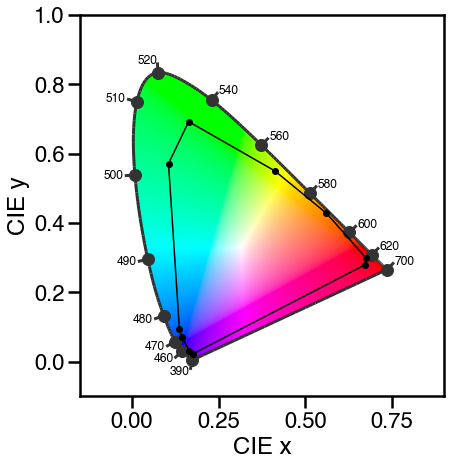

In [22]:
from colour.plotting import plot_chromaticity_diagram_CIE1931

from pyplr.CIE import get_CIE_CMF
from pyplr.stlab import spec_to_xyz

cmf = get_CIE_CMF(asdf=True, binwidth=1)

xyz = cc.data.loc[:, 4095, :].apply(lambda row: spec_to_xyz(row.to_numpy(), cmf), axis=1)
xyz = xyz.append(xyz.loc[0]).reset_index()
xyz

# set up figure
f, ax = plt.subplots(1, 1, figsize=(7,7))

# plotting the *CIE xy* chromaticity coordinates.
plot_chromaticity_diagram_CIE1931(standalone=False, axes=ax, title=False, show_spectral_locus=True)
ax.set_xlim((-.15,.9))
ax.set_ylim((-.1,1))
ax.plot(xyz['X'], xyz['Y'], color='k', lw=1.5, marker='o', markersize=6)
for item in ax.texts:
    item.set_fontsize(12)
f.savefig('../img/CIE_gamut.svg', bbox_inches='tight')

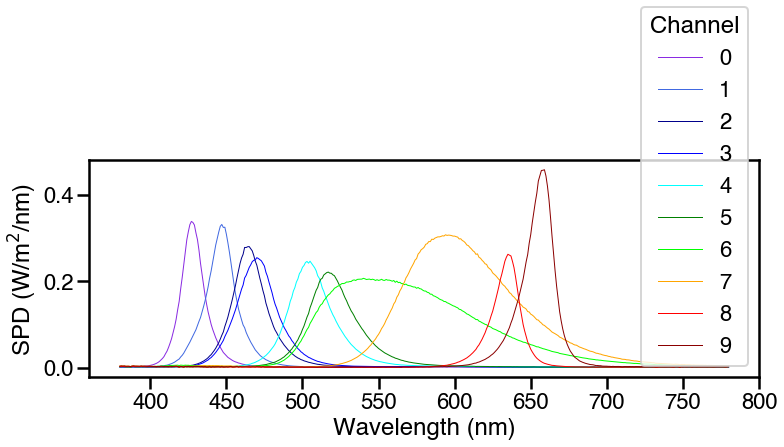

In [18]:
f, ax = plt.subplots(1, 1, figsize=(12,4))
d = cc.lkp.loc[:,4095, :]
for led, df in d.iterrows():
    color = colors[led]
    df.plot(c=color, lw=1, label=led)
ax.legend(title='Channel')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('SPD (W/m$^2$/nm)')
f.savefig('../img/STLAB_SPDs.svg', bbox_inches='tight')

In [6]:
sns.set_context('poster')

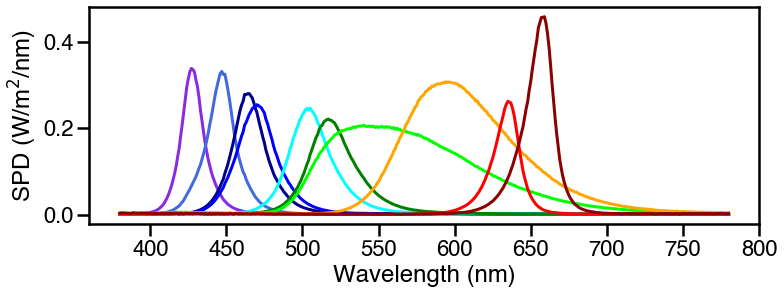

In [21]:
f, ax = plt.subplots(1, 1, figsize=(12,4))
d = cc.lkp.loc[:,4095, :]

for led, df in d.iterrows():
    color = colors[led]
    df.plot(c=color, lw=3, label=led)
#ax.legend(title='Channel')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('SPD (W/m$^2$/nm)')
f.savefig('../img/STLAB_SPDs_poster.tiff', dpi=300, bbox_inches='tight')

In [10]:
d

NameError: name 'd' is not defined

In [17]:
cc.lkp.loc[:,4095, :]

,380,381,382,383,384,385,386,387,388,389,...,771,772,773,774,775,776,777,778,779,780
led,,,,,,,,,,,,,,,,,,,,,
0,0.001947,0.002043,0.001923,0.001986,0.001822,0.001975,0.001991,0.001591,0.002169,0.002469,...,0.001000,0.001057,0.000928,0.001032,0.001017,0.001139,0.000989,0.000909,0.001029,0.001134
1,0.002188,0.002260,0.001974,0.002174,0.001751,0.001776,0.002034,0.001617,0.002012,0.002366,...,0.001185,0.001236,0.001280,0.001263,0.001252,0.001244,0.001150,0.001028,0.001205,0.001195
2,0.001692,0.001652,0.001660,0.001771,0.001520,0.001528,0.001596,0.001072,0.001764,0.001760,...,0.000983,0.001054,0.001028,0.000935,0.001170,0.000988,0.001040,0.000863,0.001099,0.001137
3,0.001705,0.001859,0.001670,0.001650,0.001484,0.001414,0.001601,0.001042,0.001673,0.001846,...,0.000927,0.001031,0.001022,0.001034,0.001107,0.001062,0.001045,0.000793,0.001074,0.001114
4,0.002172,0.002383,0.001986,0.002394,0.001776,0.001779,0.002088,0.001519,0.002115,0.002331,...,0.001290,0.001520,0.001471,0.001264,0.001391,0.001393,0.001516,0.001141,0.001382,0.001573
5,0.002222,0.002372,0.002387,0.002452,0.001999,0.001909,0.002135,0.001430,0.002443,0.002525,...,0.001329,0.001531,0.001477,0.001350,0.001548,0.001414,0.001381,0.001120,0.001461,0.001645
6,0.002364,0.002695,0.002325,0.002667,0.002139,0.002049,0.002333,0.001692,0.002430,0.002661,...,0.003608,0.003591,0.003543,0.003357,0.003521,0.003403,0.003258,0.003084,0.003262,0.003268
7,0.003669,0.004118,0.003874,0.003874,0.003333,0.003203,0.003417,0.002569,0.003896,0.004014,...,0.004860,0.004851,0.004790,0.004747,0.004703,0.004679,0.004592,0.004275,0.004212,0.004681
8,0.002452,0.002422,0.002664,0.002313,0.002143,0.001982,0.002466,0.001571,0.002640,0.002632,...,0.001476,0.001630,0.001549,0.001652,0.001757,0.001596,0.001613,0.001267,0.001625,0.001809
